In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🧾 Tiền xử lý dữ liệu người dùng
</h2>
<p style="font-size:15px; line-height:1.6; color:inherit;">
Quá trình <strong style="color:teal;">tiền xử lý dữ liệu người dùng</strong> từ các tập tin CSV thuộc bộ dữ liệu 
<code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">cresci-2015</code>. 
Các bước gồm:
</p>
<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Lựa chọn cột cần thiết:</strong>
    Giữ lại các cột quan trọng như số lượng bài đăng, người theo dõi, bạn bè, ngôn ngữ, vị trí,...
  </li>
  <li>
    <strong style="color:steelblue;">Đọc và gộp dữ liệu:</strong>
    Kết hợp hai tập tin người dùng thành một <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">DataFrame</code> duy nhất bằng <code>pd.concat</code>:
    <ul>
      <li><code style="color:yellow">E13/users.csv</code>: chứa các tài khoản <strong style="color:seagreen;">thật</strong>.</li>
      <li><code style="color:yellow;">INT/users.csv</code>: chứa các tài khoản <strong style="color:firebrick;">giả mạo</strong> (bot).</li>
    </ul>
  </li>
  <li>
    <strong style="color:steelblue;">Xử lý dữ liệu thiếu và mã hóa:</strong><br>
    <ul>
      <li>Với cột chuỗi: thay giá trị thiếu bằng <code>'NaN'</code> và mã hóa bằng <code>LabelEncoder</code>.</li>
      <li>Với cột số: thay giá trị thiếu bằng <code>0</code>.</li>
    </ul>
  </li>
</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Một bảng dữ liệu tổng hợp, sạch, đã mã hóa, chứa cả tài khoản thật và giả — sẵn sàng cho bước phân tích, huấn luyện mô hình.
</p>

In [2]:
# Chọn các cột hữu ích từ dữ liệu người dùng
useful_cols = ['id', 'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'lang', 'time_zone', 'location', 'dataset']

# Đọc dữ liệu người dùng từ các tập tin CSV, kết hợp chúng và chỉ giữ lại các cột hữu ích
users = pd.concat([
    pd.read_csv("./cresci-2015/E13/users.csv"),
    pd.read_csv("./cresci-2015/INT/users.csv")],
    ignore_index=True)[useful_cols]

# Lấp đầy các giá trị thiếu và mã hóa dữ liệu người dùng
for col in users.columns:
    if users[col].dtype == 'object':
        users[col] = LabelEncoder().fit_transform(users[col].fillna('NaN'))
    else:
        users[col] = users[col].fillna(0)
display(users)

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,time_zone,location,dataset
0,3610511,20370,5470,2385,145,52,5,29,1006,0
1,5656162,3131,506,381,9,40,1,29,1022,0
2,5682702,4024,264,87,323,16,1,29,551,0
3,6067292,40586,640,622,1118,32,1,29,793,0
4,6015122,2016,62,64,13,0,5,29,1459,0
...,...,...,...,...,...,...,...,...,...,...
2813,1391497074,1,0,17,0,0,1,23,776,1
2814,1391544607,0,1,17,0,0,1,23,793,1
2815,1391622127,2,0,15,0,0,1,23,1024,1
2816,1391832212,2,0,16,0,0,1,23,793,1


<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🔗 Xử lý dữ liệu bạn bè và xây dựng cạnh đồ thị
</h2>
<p style="font-size:15px; line-height:1.6; color:inherit;">
Đây là bước quan trọng tạo ra <strong style="color:teal;">danh sách các cạnh (connections)</strong> giữa các người dùng để xây dựng đồ thị mạng xã hội đầu vào cho các mô hình <strong style="color:teal;">GNN</strong>. Các bước gồm:
</p>
<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Tải và gộp dữ liệu bạn bè:</strong>
    Đọc hai tập tin <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">E13/friends.csv</code> và <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">INT/friends.csv</code>, sau đó gộp lại thành một bảng duy nhất chứa các quan hệ bạn bè giữa người dùng.
  </li>
  <li>
    <strong style="color:steelblue;">Tạo chỉ mục người dùng:</strong>
    Tạo một ánh xạ từ <code>user_id</code> sang chỉ số hàng trong bảng <code style="background-color:rgba(255,165,0,0.1); padding:2px 6px; border-radius:4px;">users</code>, giúp truy xuất nhanh trong bước xây dựng cạnh.
  </li>
  <li>
    <strong style="color:steelblue;">Tạo danh sách cạnh (edge list):</strong>
    Từ dữ liệu bạn bè, tạo hai chiều kết nối (vô hướng) giữa các người dùng bằng cách ánh xạ <code>source_id</code> và <code>target_id</code> sang chỉ mục người dùng:
    <ul>
      <li>Loại bỏ các hàng có giá trị thiếu</li>
      <li>Loại bỏ các cặp trùng lặp và tự kết nối (self-loop)</li>
    </ul>
  </li>
</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
  <strong>✅ Kết quả:</strong> Một bảng <strong style="color:teal;">edge</strong> đại diện danh sách các cạnh (kết nối giữa người dùng), dùng làm cấu trúc đồ thị đầu vào cho các mô hình <strong style="color:teal;">GNN</strong>.
</p>

In [3]:
# Tải dữ liệu bạn bè từ các tập tin CSV và kết hợp chúng
friends = pd.concat([
    pd.read_csv("./cresci-2015/E13/friends.csv"), 
    pd.read_csv("./cresci-2015/INT/friends.csv")], 
    ignore_index=True)
display(friends)

# Tạo chỉ mục cho người dùng để ánh xạ ID người dùng sang chỉ mục
users_index = {id: index for index, id in enumerate(users.id)}

# Tạo DataFrame cho các cạnh (edge) từ dữ liệu bạn bè
edge = pd.concat([
    pd.DataFrame({
        'source_index': friends['source_id'].map(users_index),
        'target_index': friends['target_id'].map(users_index)
    }),
    pd.DataFrame({
        'source_index': friends['target_id'].map(users_index),
        'target_index': friends['source_id'].map(users_index)
    })
]).dropna().drop_duplicates().query("source_index != target_index").reset_index(drop=True).astype({'source_index': 'long', 'target_index': 'long'})
display(edge)

,source_id,target_id
0,3610511,12
1,3610511,13
2,3610511,380
3,3610511,418
4,3610511,586
...,...,...
1184705,1391998039,617407144
1184706,1391998039,980980376
1184707,1391998039,1014680358
1184708,1391998039,1359182538


,source_index,target_index
0,0,8
1,0,25
2,0,30
3,0,45
4,0,239
...,...,...
4555,1688,2586
4556,2489,2599
4557,2082,2624
4558,1566,2660


<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🧠 Chuyển đổi dữ liệu thành graph tensor
</h2>
<p style="font-size:15px; line-height:1.6; color:inherit;">
Chuyển đổi toàn bộ dữ liệu người dùng và các mối quan hệ (cạnh) thành một cấu trúc đồ thị (graph) dùng cho các mô hình <strong style="color:teal;">GNN</strong>. Các bước chính:
</p>
<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Tạo tensor đặc trưng (x):</strong>
    Từ bảng <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">users</code>, loại bỏ các cột không dùng (<code>id</code>, <code>dataset</code>) và chuyển thành tensor.
  </li>
  <li>
    <strong style="color:steelblue;">Tạo tensor cạnh (edge_index):</strong>
    Chuyển cặp <code>source_index</code> và <code>target_index</code> thành tensor định dạng [2, num_edges] để sử dụng trong <code>PyTorch Geometric</code>. Thêm các <strong style="color:goldenrod;">self-loops</strong> để tăng ổn định huấn luyện.
  </li>
  <li>
    <strong style="color:steelblue;">Chuyển đổi nhãn (y):</strong>
    Lấy cột <code>dataset</code> làm nhãn phân loại, tương ứng với nhãn tài khoản thật hoặc giả.
  </li>
  <li>
    <strong style="color:steelblue;">Tạo đối tượng đồ thị:</strong>
    Kết hợp đặc trưng <code>x</code>, cạnh <code>edge_index</code> và nhãn <code>y</code> vào một đối tượng 
    <code style="background-color:rgba(255,105,180,0.1); padding:2px 6px; border-radius:4px;">Data</code> 
    (của <code style="background-color:rgba(255,165,0,0.1); padding:2px 6px; border-radius:4px;">PyG</code>), đại diện cho toàn bộ đồ thị người dùng.
  </li>
</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Đối tượng <strong style="color:teal;">graph</strong> kiểu <strong style="color:teal;">torch_geometric.data.Data</strong> sẵn sàng được dùng để huấn luyện các mô hình <strong style="color:tea_

In [4]:
# Chuyển đổi dữ liệu người dùng thành tensor
x = users.drop(['id','dataset'], axis=1).values
x = torch.tensor(x, dtype=torch.float)

# Chuyển đổi dữ liệu cạnh thành tensor và thêm thêm các cạnh tự nối (self-loops)
edge_index = torch.tensor(edge[['source_index', 'target_index']].values, dtype=torch.long).t().contiguous()
edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

# Chuyển đổi nhãn người dùng thành tensor
y = torch.tensor(users.dataset, dtype=torch.long)

# Tạo đối tượng graph từ dữ liệu người dùng, các cạnh và nhãn
graph = Data(x=x, edge_index=edge_index, y=y)
display(graph)

Data(x=[2818, 8], edge_index=[2, 7378], y=[2818])

<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🧪 Chia dữ liệu và tạo mask cho huấn luyện & kiểm tra
</h2>
<p style="font-size:15px; line-height:1.6; color:inherit;">
Chia các nút trong đồ thị thành tập huấn luyện và kiểm tra, sau đó tạo các 
<code style="background-color:rgba(255,192,203,0.1); padding:2px 6px; border-radius:4px;">mask</code> 
tương ứng để sử dụng trong quá trình huấn luyện mô hình GNN. Các bước cụ thể:
</p>
<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Xác định số lượng nút:</strong>
    Sử dụng thuộc tính <code>graph.num_nodes</code> để lấy tổng số node trong đồ thị.
  </li>
  <li>
    <strong style="color:steelblue;">Chia dữ liệu thành tập huấn luyện và kiểm tra:</strong>
    Dùng <code>train_test_split</code> với tỷ lệ 70% train – 30% test và 
    <code>stratify</code> theo nhãn <code>dataset</code> để đảm bảo phân bố lớp đều trong cả hai tập.
  </li>
  <li>
    <strong style="color:steelblue;">Tạo các mask boolean:</strong>
    Khởi tạo hai tensor kiểu <code>torch.bool</code> có kích thước bằng số node, dùng để đánh dấu node thuộc tập train hoặc test.
  </li>
  <li>
    <strong style="color:steelblue;">Gán mask vào graph:</strong>
    Các vị trí tương ứng với chỉ mục train/test được gán <code>True</code> trong mask, rồi gán trực tiếp vào thuộc tính 
    <code>graph.train_mask</code> và <code>graph.test_mask</code>.
  </li>
</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Đồ thị <strong style="color:teal;">graph</strong> đã được gán mask để phân biệt các node dùng cho huấn luyện và kiểm tra — cần thiết cho quá trình đánh giá mô hình GCN một cách chính xác.
</p>

In [5]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
num_nodes = graph.num_nodes
train, test = train_test_split(
    range(num_nodes),
    test_size=0.3, 
    random_state=42,
    stratify=users.dataset.to_numpy()
)

# Tạo mask cho tập huấn luyện và tập kiểm tra
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Gán giá trị True cho các chỉ mục trong tập huấn luyện và tập kiểm tra
train_mask[train] = True
test_mask[test] = True

# Gán các mask vào đối tượng graph
graph.train_mask = train_mask
graph.test_mask = test_mask
print(f"Train nodes: {graph.train_mask.sum()}, Test nodes: {graph.test_mask.sum()}")

Train nodes: 1972, Test nodes: 846


<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🧱 Khởi tạo mô hình GCN
</h2>

<p style="font-size:15px; line-height:1.6; color:inherit;">
Kiến trúc của mô hình <strong style="color:teal;">Graph Convolutional Network (GCN)</strong> sử dụng 
<code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">PyTorch Geometric</code>, gồm 2 lớp tích chập trên đồ thị. 
Sau khi định nghĩa, mô hình được khởi tạo dựa trên dữ liệu đầu vào.
</p>

<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Định nghĩa lớp <code>GCN</code>:</strong>
    Gồm 2 lớp <code>GCNConv</code>:
    <ul>
      <li><code>conv1</code>: từ <code>in_channels</code> đến <code>hidden_channels</code></li>
      <li><code>conv2</code>: từ <code>hidden_channels</code> đến <code>num_classes</code></li>
    </ul>
  </li>

  <li>
    <strong style="color:steelblue;">Forward pass:</strong>
    <ul>
      <li>Truyền dữ liệu qua <code>conv1</code> → <code>ReLU</code> → <code>Dropout</code></li>
      <li>Tiếp tục truyền qua <code>conv2</code> và áp dụng <code>Softmax</code> để ra xác suất phân lớp</li>
    </ul>
  </li>

  <li>
    <strong style="color:steelblue;">Công thức lan truyền của GCN:</strong><br>
    <span style="font-size:15px;">GCN lan truyền thông tin theo công thức chuẩn hóa sau:</span>
  </li>

$$
H^{(l+1)} = \sigma\left( \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(l)} W^{(l)} \right)
$$

  <ul>
      <li><code>H<sup>(l)</sup></code>: ma trận đặc trưng tại lớp thứ <code>l</code></li>
      <li><code>W<sup>(l)</sup></code>: trọng số học được của lớp <code>l</code></li>
      <li><code>σ</code>: hàm kích hoạt (ReLU)</li>
      <li><code>Ã = A + I</code>: ma trận kề có self-loop</li>
      <li><code>D̃</code>: ma trận bậc tương ứng với <code>Ã</code></li>
  </ul>
  <li>
    <strong style="color:steelblue;">Khởi tạo mô hình:</strong>
    Mô hình được tạo với:
    <ul>
      <li><code>in_channels</code>: số đặc trưng mỗi node = <code>graph.num_node_features</code></li>
      <li><code>hidden_channels</code>: 64</li>
      <li><code>num_classes</code>: số nhãn phân loại từ <code>users.dataset</code></li>
    </ul>
  </li>
</ol>

<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Mô hình <strong style="color:teal;">GCN</strong> hai lớp được khởi tạo sẵn sàng để huấn luyện với cấu trúc đồ thị người dùng, nhằm phân loại tài khoản 
<strong style="color:teal;">thật</strong> và <strong style="color:firebrick;">giả</strong>.
</p>

In [6]:
# Định nghĩa mô hình GCN
class GAT(torch.nn.Module):
    # Phương thức khởi tạo kiến trúc mô hình GCN
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, num_classes)
        
    # Phương thức forward để thực hiện quá trình lan truyền qua các lớp GCNConv
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.softmax(x, dim=1)
        return x

# Khởi tạo mô hình GCN cụ thể
model = GAT(graph.num_node_features, 64, len(np.unique(users.dataset)))
display(model)

GAT(
  (conv1): GATConv(8, 64, heads=1)
  (conv2): GATConv(64, 2, heads=1)
)

<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
🏋️‍♂️ Huấn luyện và đánh giá mô hình GCN
</h2>

<p style="font-size:15px; line-height:1.6; color:inherit;">
Thiết lập bộ tối ưu hóa và định nghĩa hai hàm <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">train()</code> 
và <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">test()</code> phục vụ quá trình huấn luyện và kiểm tra độ chính xác 
của mô hình <strong style="color:teal;">GCN</strong>.
</p>

<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Khởi tạo bộ tối ưu hóa:</strong>
    Sử dụng <code>torch.optim.Adam</code> để cập nhật trọng số của mô hình với:
    <ul>
      <li><code>lr = 0.01</code>: tốc độ học</li>
      <li><code>weight_decay = 5e-4</code>: hệ số regularization để giảm overfitting</li>
    </ul>
  </li>

  <li>
    <strong style="color:steelblue;">Hàm huấn luyện <code>train()</code>:</strong>
    <ul>
      <li>Đặt mô hình ở chế độ huấn luyện bằng <code>model.train()</code></li>
      <li>Thực hiện forward pass để dự đoán</li>
      <li>Tính toán hàm mất mát cross-entropy trên <code>graph.train_mask</code></li>
      <li>Lan truyền ngược và cập nhật trọng số</li>
    </ul>
    <p style="margin-top:10px;"><strong>Hàm mất mát:</strong></p>
  </li>

$$
\mathcal{L}_{\text{train}} = - \sum_{i \in \text{Train}} y_i \cdot \log(\hat{y}_i)
$$

  <li>
    <strong style="color:steelblue;">Hàm kiểm tra <code>test()</code>:</strong>
    <ul>
      <li>Chuyển mô hình sang chế độ đánh giá bằng <code>model.eval()</code></li>
      <li>Dự đoán nhãn qua <code>argmax</code> trên đầu ra</li>
      <li>Tính độ chính xác trên cả tập huấn luyện và kiểm tra</li>
    </ul>
    <p style="margin-top:10px;"><strong>Công thức độ chính xác:</strong></p>
  </li>

$$
\text{Accuracy} = \frac{\text{Số lượng dự đoán đúng}}{\text{Tổng số mẫu trong tập}}
$$

</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Quá trình huấn luyện nhiều epoch, giúp mô hình học phân biệt tài khoản 
<strong style="color:teal;">thật</strong> và <strong style="color:firebrick;">giả</strong> trên đồ thị người dùng.
</p>

In [7]:
# Khởi tạo bộ tối ưu hóa Adam với mô hình và các tham số học
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
display(optimizer)

# Phương thức huấn luyện mô hình
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index)
    loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Phương thức kiểm tra mô hình
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph.x, graph.edge_index)
        pred = out.argmax(dim=1)
    accs = []
    for mask in [graph.train_mask, graph.test_mask]:
        correct = pred[mask] == graph.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        accs.append(acc)
    return accs

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.02
    maximize: False
    weight_decay: 0.0005
)

In [8]:
# Khởi tạo DataFrame để lưu lịch sử huấn luyện
history = pd.DataFrame(columns=['epoch', 'loss', 'train_acc', 'test_acc'])

# Huấn luyện mô hình và lưu lịch sử huấn luyện
for epoch in range(1, 101):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    history.loc[len(history)] = {
        'epoch': epoch,
        'loss': loss,
        'train_acc': train_acc,
        'test_acc': test_acc
    }

Epoch: 001, Loss: 0.9620, Train Acc: 0.5614, Test Acc: 0.5461
Epoch: 002, Loss: 0.7607, Train Acc: 0.5553, Test Acc: 0.5437
Epoch: 003, Loss: 0.7538, Train Acc: 0.6831, Test Acc: 0.6714
Epoch: 004, Loss: 0.6808, Train Acc: 0.7170, Test Acc: 0.7057
Epoch: 005, Loss: 0.6256, Train Acc: 0.7617, Test Acc: 0.7411
Epoch: 006, Loss: 0.6057, Train Acc: 0.7890, Test Acc: 0.7801
Epoch: 007, Loss: 0.5824, Train Acc: 0.8022, Test Acc: 0.8038
Epoch: 008, Loss: 0.5414, Train Acc: 0.8550, Test Acc: 0.8511
Epoch: 009, Loss: 0.4811, Train Acc: 0.8621, Test Acc: 0.8617
Epoch: 010, Loss: 0.4720, Train Acc: 0.8687, Test Acc: 0.8652
Epoch: 011, Loss: 0.4755, Train Acc: 0.8753, Test Acc: 0.8712
Epoch: 012, Loss: 0.4537, Train Acc: 0.8788, Test Acc: 0.8771
Epoch: 013, Loss: 0.4489, Train Acc: 0.8940, Test Acc: 0.8865
Epoch: 014, Loss: 0.4360, Train Acc: 0.9042, Test Acc: 0.8936
Epoch: 015, Loss: 0.4401, Train Acc: 0.9189, Test Acc: 0.9149
Epoch: 016, Loss: 0.4012, Train Acc: 0.9239, Test Acc: 0.9243
Epoch: 0

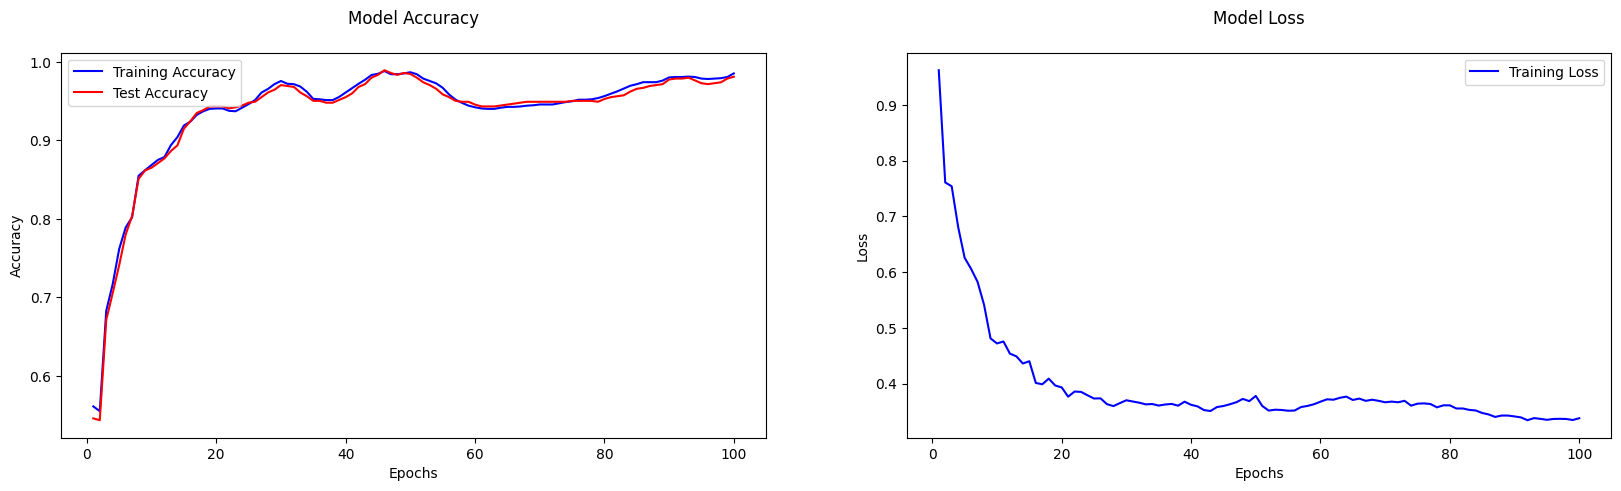

In [9]:
# Gán dữ liệu lịch sử huấn luyện vào các biến để vẽ biểu đồ
loss = history['loss']
train_accuracy = history['train_acc']
test_accuracy = history['test_acc']
epochs = range(1, len(history['loss']) + 1)

# Đặt kích thước biểu đồ
plt.figure(figsize=(20, 5))

# Vẽ biểu đồ chính xác
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b-', label="Training Accuracy")
plt.plot(epochs, test_accuracy, 'r-', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy\n")
plt.legend()

# Vẽ biểu đồ mất mát
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss\n")
plt.legend()

# Hiển thị biểu đồ
plt.show()

<h2 style="color:inherit; font-family:Arial, sans-serif; border-bottom:2px solid currentColor; padding-bottom:6px;">
📊 Đánh giá hiệu suất mô hình GCN
</h2>
<p style="font-size:15px; line-height:1.6; color:inherit;">
Sau khi huấn luyện mô hình <strong style="color:teal;">GCN</strong>, thực hiện đánh giá toàn diện trên toàn bộ đồ thị người dùng thông qua các chỉ số:
</p>
<ol style="font-size:15px; line-height:1.8; color:inherit;">
  <li>
    <strong style="color:steelblue;">Độ chính xác tổng thể (Accuracy):</strong><br>
    <p>Phần trăm mẫu được phân loại đúng trên toàn bộ tập dữ liệu:</p>
  </li>

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^N \mathbf{1}(y_i = \hat{y}_i)
$$

  <li>
    <strong style="color:steelblue;">Ma trận nhầm lẫn:</strong><br>
    <p>Hiển thị số lượng dự đoán đúng/sai giữa các lớp 
      <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">Real</code> 
      và <code style="background-color:rgba(128,128,128,0.1); padding:2px 6px; border-radius:4px;">Fake</code>.
    </p>
  </li>
  <li>
    <strong style="color:steelblue;">Báo cáo phân loại (Classification Report):</strong>
    <p>Gồm 3 chỉ số cơ bản cho từng lớp:</p>
    <ul>
      <li><strong style="color:seagreen;">Precision</strong> – Độ chính xác dương tính:</li>
    </ul>

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

  <ul>
    <li><strong style="color:seagreen;">Recall</strong> – Tỷ lệ phát hiện đúng (độ nhạy):</li>
  </ul>

$$
\text{Recall} = \frac{TP}{TP + FN}
$$
  
  <ul>
    <li><strong style="color:seagreen;">F1-score</strong> – Trung bình điều hòa giữa Precision và Recall:</li>
  </ul>

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

  </li>
  <li>
    <strong style="color:steelblue;">Biểu đồ ROC và AUC:</strong>
    <p>Đánh giá khả năng phân biệt giữa hai lớp bằng diện tích dưới đường cong ROC:</p>
  </li>

$$
\text{AUC} = \int_0^1 \text{TPR}(FPR) \, d(\text{FPR})
$$

</ol>
<p style="background-color:rgba(0,128,0,0.05); padding:12px 16px; border-left:5px solid seagreen; border-radius:6px; color:inherit;">
<strong>✅ Kết quả:</strong> Các chỉ số định lượng và biểu đồ trực quan được sử dụng để đánh giá toàn diện hiệu suất mô hình 
<strong style="color:teal;">GCN</strong>.
</p>


              precision    recall  f1-score   support

        Real       0.99      0.98      0.98      1481
        Fake       0.97      0.99      0.98      1337

    accuracy                           0.98      2818
   macro avg       0.98      0.98      0.98      2818
weighted avg       0.98      0.98      0.98      2818



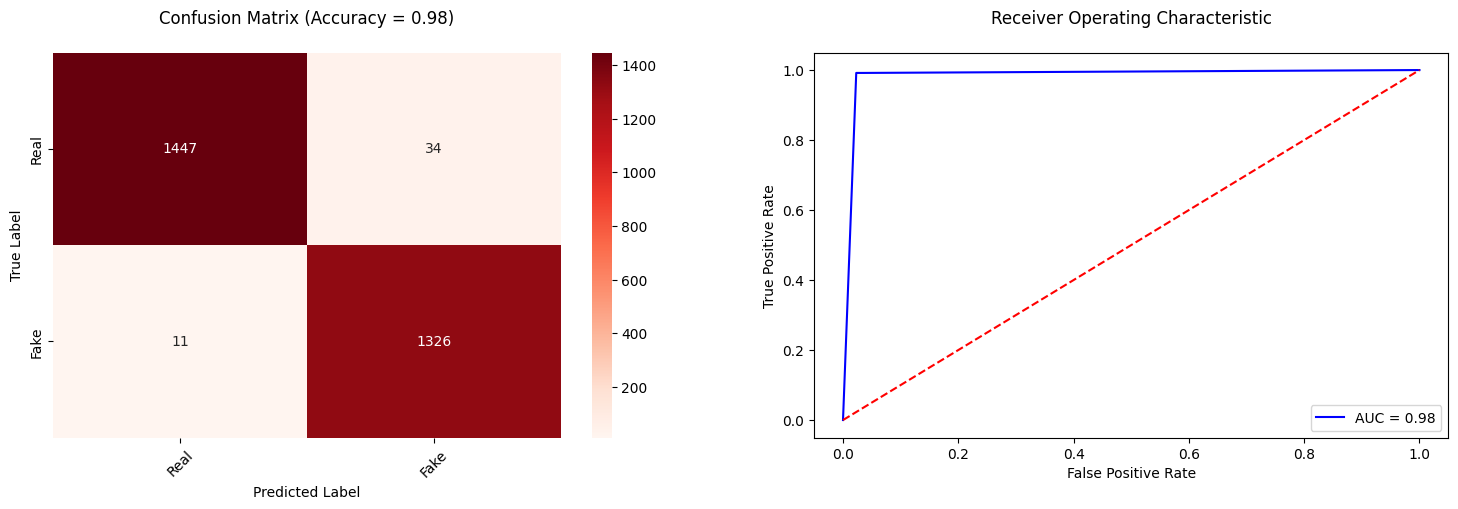

In [10]:
# Kiểm tra trên toàn bộ dữ liệu huấn luyện
model.eval()
with torch.no_grad():
    out = model(graph.x, graph.edge_index)
    predictions = out.argmax(dim=1).numpy()
    acc = (predictions == graph.y.numpy()).sum() / graph.y.size(0)
    true_labels = graph.y.numpy()
    probs = out[:, 1].numpy()
cm = confusion_matrix(graph.y.numpy(), predictions)
roc_auc = roc_auc_score(true_labels, probs)
fpr, tpr, thresholds = roc_curve(true_labels, probs)

# Hiển thị các chỉ số đánh giá mô hình
print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))

# Đặt kích thước biểu đồ
plt.figure(figsize=(18, 5))

# Vẽ ma trận nhầm lẫn
plt.subplot(1, 2, 1)
class_names = ['Real', 'Fake']
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy = {acc:.2f})\n')

# Vẽ biểu đồ ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # baseline
plt.title("Receiver Operating Characteristic\n")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Hiển thị biểu đồ
plt.show()